In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D, Dropout
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import shap
import warnings
warnings.filterwarnings('ignore')
import pydot

## Encoder-DecoderアーキテクチャのLSTMで予想

### Configs

In [177]:
class CFG:

    n_steps = 12 #Sliding Windowのステップ数
    n_lookup = 1 #予測ステップ数
    
    N_SAMPLE = 1 #N回回して平均を取る
    epochs = 100

In [178]:
def rmsle(y_true, y_pred):

    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    
    return K.sqrt(msle(y_true, y_pred))

### まずはデータの準備

In [179]:
df_train = pd.read_csv('train_features_added.csv')
df_test = pd.read_csv('test_features_added.csv')

In [180]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

features = df_train.columns.to_list()
features.remove('date_time')
features.remove('month')
features.remove('day')
features.remove('hour')
features.remove('day_of_year')


for t in targets:

    features.remove(t)


targets_values = np.concatenate([df_train[[targets[0]]], df_train[[targets[1]]], df_train[[targets[2]]]], axis=1)


df_test = pd.concat([df_train[len(df_train)-CFG.n_steps-1:len(df_train)-1].drop(targets , axis=1), df_test])
df_all = pd.concat([df_train.drop(targets , axis=1), df_test])

df_all['date_time'] = pd.to_datetime(df_all['date_time'])
df_train['date_time'] = pd.to_datetime(df_train['date_time'])
df_test['date_time'] = pd.to_datetime(df_test['date_time'])

df_train.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)

目的変数ごとにデータフレームを分ける

In [181]:
df_all_CO = df_all[features]
df_all_C6H6 = df_all[features]
df_all_NOx = df_all[features]

df_train_CO = df_all_CO[:len(df_train)]
df_train_CO[targets[0]] = targets_values[:, 0]

df_train_C6H6 = df_all_C6H6[:len(df_train)]
df_train_C6H6[targets[1]] = targets_values[:, 1]

df_train_NOx = df_all_NOx[:len(df_train)]
df_train_NOx[targets[2]] = targets_values[:, 2]

df_test_CO = df_all_CO[len(df_train):]
df_test_C6H6 = df_all_C6H6[len(df_train):]
df_test_NOx = df_all_NOx[len(df_train):]

説明変数をMin -1, Max 1で正規化

In [182]:
scaler = MinMaxScaler(feature_range=(-1,1))

for i in features:
    df_train_CO[i] = scaler.fit_transform(df_train_CO[i].values.reshape(-1,1))
    df_test_CO[i] = scaler.fit_transform(df_test_CO[i].values.reshape(-1,1))

for i in features:
    df_train_C6H6[i] = scaler.fit_transform(df_train_C6H6[i].values.reshape(-1,1))
    df_test_C6H6[i] = scaler.fit_transform(df_test_C6H6[i].values.reshape(-1,1))

for i in features:
    df_train_NOx[i] = scaler.fit_transform(df_train_NOx[i].values.reshape(-1,1))
    df_test_NOx[i] = scaler.fit_transform(df_test_NOx[i].values.reshape(-1,1))

In [183]:
train_CO, val_CO = train_test_split(df_train_CO, shuffle = False, train_size=0.8)
train_C6H6, val_C6H6 = train_test_split(df_train_C6H6, shuffle = False, train_size=0.8)
train_NOx, val_NOx = train_test_split(df_train_NOx, shuffle = False, train_size=0.8)

説明変数はn_steps, 目的変数はn_lookupのウィンドウ幅で分割する

In [184]:
def devide_by_sliding_window(Xseq, yseq, n_steps=CFG.n_steps, n_lookup=CFG.n_lookup):
    X, y = list(), list()

    for i in range(len(Xseq)):
        end_index = i + n_steps
        out_end_index = end_index + n_lookup
        
        if out_end_index > len(Xseq):
            break
        
        seq_x = Xseq.iloc[i:end_index, :]
        X.append(seq_x)

        if isinstance(yseq, pd.core.series.Series):
            seq_y = yseq.iloc[end_index:out_end_index]
            y.append(seq_y)

    return np.array(X), np.array(y)

In [185]:
Xtrain_seq_CO, Ytrain_seq_CO = devide_by_sliding_window(train_CO.drop(targets[0], axis=1), train_CO[targets[0]], CFG.n_steps, CFG.n_lookup)
Xval_seq_CO, Yval_seq_CO = devide_by_sliding_window(val_CO.drop(targets[0], axis=1), val_CO[targets[0]], CFG.n_steps, CFG.n_lookup)

Xtrain_seq_C6H6, Ytrain_seq_C6H6 = devide_by_sliding_window(train_C6H6.drop(targets[1], axis=1), train_C6H6[targets[1]], CFG.n_steps, CFG.n_lookup)
Xval_seq_C6H6, Yval_seq_C6H6 = devide_by_sliding_window(val_C6H6.drop(targets[1], axis=1), val_C6H6[targets[1]], CFG.n_steps, CFG.n_lookup)

Xtrain_seq_NOx, Ytrain_seq_NOx = devide_by_sliding_window(train_NOx.drop(targets[2], axis=1), train_NOx[targets[2]], CFG.n_steps, CFG.n_lookup)
Xval_seq_NOx, Yval_seq_NOx = devide_by_sliding_window(val_NOx.drop(targets[2], axis=1), val_NOx[targets[2]], CFG.n_steps, CFG.n_lookup)

n_features = Xtrain_seq_CO.shape[2]

In [186]:
print(Xtrain_seq_CO.shape, Ytrain_seq_CO.shape)
print(Xval_seq_CO.shape, Yval_seq_CO.shape)
print(Xtrain_seq_C6H6.shape, Ytrain_seq_C6H6.shape)
print(Xval_seq_C6H6.shape, Yval_seq_C6H6.shape)
print(Xtrain_seq_NOx.shape, Ytrain_seq_NOx.shape)
print(Xval_seq_NOx.shape, Yval_seq_NOx.shape)

(5676, 12, 21) (5676, 1)
(1411, 12, 21) (1411, 1)
(5676, 12, 21) (5676, 1)
(1411, 12, 21) (1411, 1)
(5676, 12, 21) (5676, 1)
(1411, 12, 21) (1411, 1)


In [187]:
Xtest_sub_CO, _ = devide_by_sliding_window(df_test_CO, [], CFG.n_steps, CFG.n_lookup)
Xtest_sub_C6H6, _ = devide_by_sliding_window(df_test_C6H6, [], CFG.n_steps, CFG.n_lookup)
Xtest_sub_NOx, _ = devide_by_sliding_window(df_test_NOx, [], CFG.n_steps, CFG.n_lookup)

### モデル作成

In [188]:
def plot_model_learning(history, target):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.title(target)
    plt.show()

コールバック作成

In [189]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

logs='./logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, update_freq='epoch')

学習率スケジューラー

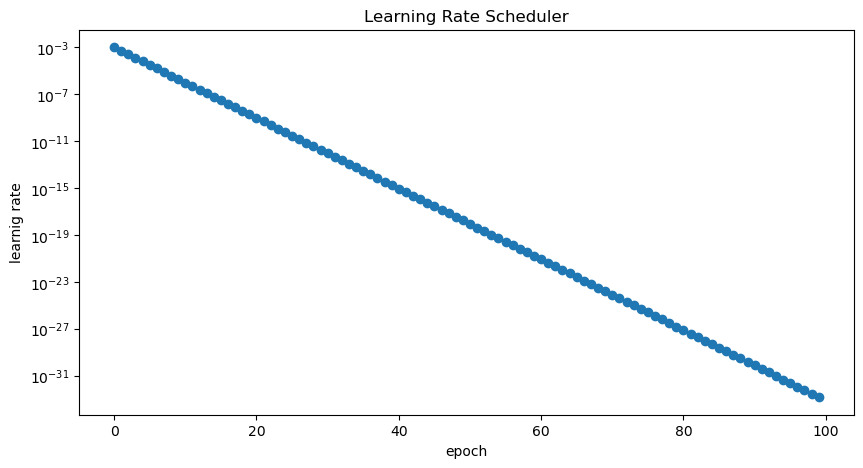

In [190]:
def get_lr_callback_CO(plot=False):

    initial_lr = 1e-3
   
    def lrfn(epoch):

        lr = initial_lr * 0.50 ** epoch

        return lr
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
    return lr_callback

get_lr_callback_CO(plot=True)

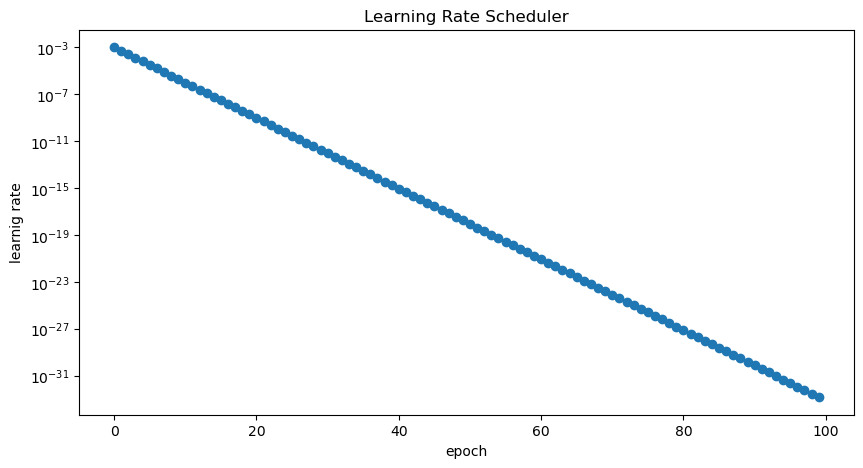

In [191]:
def get_lr_callback_C6H6(plot=False):

    initial_lr = 1e-3
   
    def lrfn(epoch):

        lr = initial_lr * 0.50 ** epoch

        return lr
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
    return lr_callback

get_lr_callback_C6H6(plot=True)

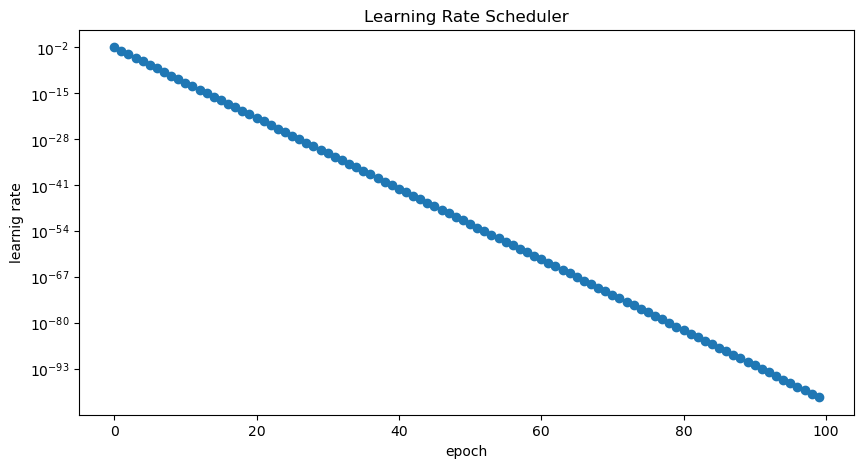

In [192]:
def get_lr_callback_NOx(plot=False):

    initial_lr = 1e-2
   
    def lrfn(epoch):

        lr = initial_lr * 0.10 ** epoch

        return lr
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
    return lr_callback

get_lr_callback_NOx(plot=True)

回してみます

In [193]:
model_CO = Sequential()
model_CO.add(LSTM(256, activation='tanh', input_shape=(CFG.n_steps, n_features)))
model_CO.add(RepeatVector(CFG.n_lookup))
model_CO.add(LSTM(256, activation='tanh', return_sequences=True))
model_CO.add(TimeDistributed(Dense(1)))
model_CO.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)          
model_CO.summary()


Y_CO = np.zeros((Xtest_sub_CO.shape[0], 1))
Y_CO_val = np.zeros((Xval_seq_CO.shape[0], 1))


for samples in tqdm(range(CFG.N_SAMPLE)):

    tf.keras.backend.clear_session()

    model_CO.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02), loss= rmsle)
    history_CO = model_CO.fit(Xtrain_seq_CO, Ytrain_seq_CO, 
                            validation_data=(Xval_seq_CO, Yval_seq_CO), 
                            epochs=CFG.epochs, 
                            verbose = 0,
                            batch_size = 16, 
                            callbacks=[es_callback, get_lr_callback_CO(), tb_callback])
    
    Y_CO_val += (model_CO.predict(Xval_seq_CO)).reshape(-1,1)
    Y_CO += (model_CO.predict(Xtest_sub_CO)).reshape(-1,1)


Y_CO_val = (Y_CO_val / CFG.N_SAMPLE).clip(min=0)
Y_CO = (Y_CO / CFG.N_SAMPLE).clip(min=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               284672    
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              257       
 ributed)                                                        
                                                                 
Total params: 810241 (3.09 MB)
Trainable params: 810241 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  0%|          | 0/1 [00:00<?, ?it/s]

71/71 [==============================] - 0s 4ms/step


100%|██████████| 1/1 [01:13<00:00, 73.59s/it]


In [194]:
model_C6H6 = Sequential()
model_C6H6.add(LSTM(256, activation='tanh', input_shape=(CFG.n_steps, n_features)))
model_C6H6.add(RepeatVector(CFG.n_lookup))
model_C6H6.add(LSTM(256, activation='tanh', return_sequences=True))
model_C6H6.add(TimeDistributed(Dense(1)))
model_C6H6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)          
model_C6H6.summary()


Y_C6H6 = np.zeros((Xtest_sub_C6H6.shape[0], 1))
Y_C6H6_val = np.zeros((Xval_seq_C6H6.shape[0], 1))


for samples in tqdm(range(CFG.N_SAMPLE)):

    tf.keras.backend.clear_session()

    model_C6H6.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02), loss= rmsle)
    history_C6H6 = model_C6H6.fit(Xtrain_seq_C6H6, Ytrain_seq_C6H6, 
                            validation_data=(Xval_seq_C6H6, Yval_seq_C6H6), 
                            epochs=CFG.epochs, 
                            verbose = 0,
                            batch_size = 16, 
                            callbacks=[es_callback, get_lr_callback_C6H6(), tb_callback])
    
    Y_C6H6 += (model_C6H6.predict(Xtest_sub_C6H6)).reshape(-1,1)
    Y_C6H6_val += (model_C6H6.predict(Xval_seq_C6H6)).reshape(-1,1)


Y_C6H6_val = (Y_C6H6_val / CFG.N_SAMPLE).clip(min=0)
Y_C6H6 = (Y_C6H6 / CFG.N_SAMPLE).clip(min=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               284672    
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              257       
 ributed)                                                        
                                                                 
Total params: 810241 (3.09 MB)
Trainable params: 810241 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  0%|          | 0/1 [00:00<?, ?it/s]

45/45 [==============================] - 0s 5ms/step


100%|██████████| 1/1 [01:21<00:00, 81.17s/it]


In [195]:
Yval_seq_NOx

array([[149.5],
       [221.8],
       [279.2],
       ...,
       [227.4],
       [199.8],
       [186.5]])

In [196]:
model_NOx = Sequential()
model_NOx.add(LSTM(24, activation='tanh', input_shape=(CFG.n_steps, n_features)))
model_NOx.add(RepeatVector(CFG.n_lookup))
model_NOx.add(LSTM(24, activation='tanh', return_sequences=True))
model_NOx.add(TimeDistributed(Dense(1)))
model_NOx.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)          
model_NOx.summary()


Y_NOx = np.zeros((Xtest_sub_NOx.shape[0], 1))
Y_NOx_val = np.zeros((Xval_seq_NOx.shape[0], 1))


for samples in tqdm(range(CFG.N_SAMPLE)):

    tf.keras.backend.clear_session()

    model_NOx.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02), loss= rmsle)
    history_NOx = model_NOx.fit(Xtrain_seq_NOx, Ytrain_seq_NOx, 
                            validation_data=(Xval_seq_NOx, Yval_seq_NOx), 
                            epochs=CFG.epochs, 
                            verbose = 0,
                            batch_size = 16, 
                            callbacks=[es_callback, get_lr_callback_NOx(), tb_callback])
    
    Y_NOx += (model_NOx.predict(Xtest_sub_NOx)).reshape(-1,1)
    Y_NOx_val += (model_NOx.predict(Xval_seq_NOx)).reshape(-1,1)


Y_NOx_val = (Y_NOx_val / CFG.N_SAMPLE).clip(min=0)
Y_NOx = (Y_NOx / CFG.N_SAMPLE).clip(min=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                4416      
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 24)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 24)             4704      
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              25        
 ributed)                                                        
                                                                 
Total params: 9145 (35.72 KB)
Trainable params: 9145 (35.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  0%|          | 0/1 [00:00<?, ?it/s]

45/45 [==============================] - 0s 4ms/step


100%|██████████| 1/1 [01:04<00:00, 64.34s/it]


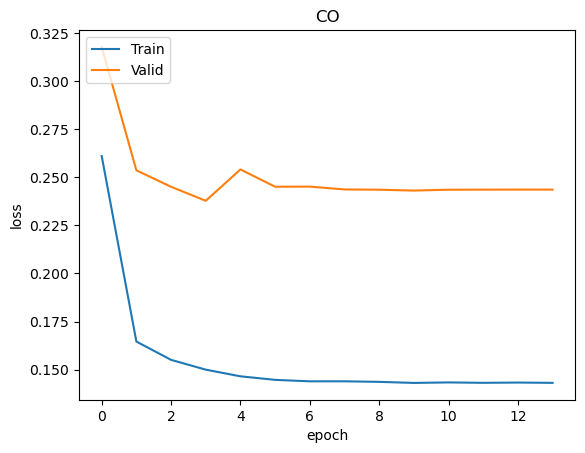

In [197]:
plot_model_learning(history_CO, 'CO')

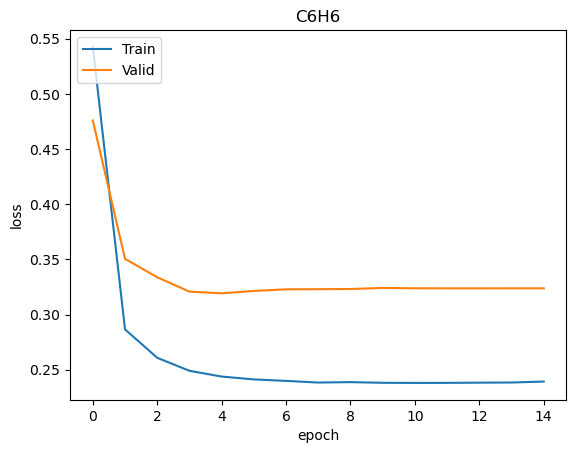

In [198]:
plot_model_learning(history_C6H6, 'C6H6')

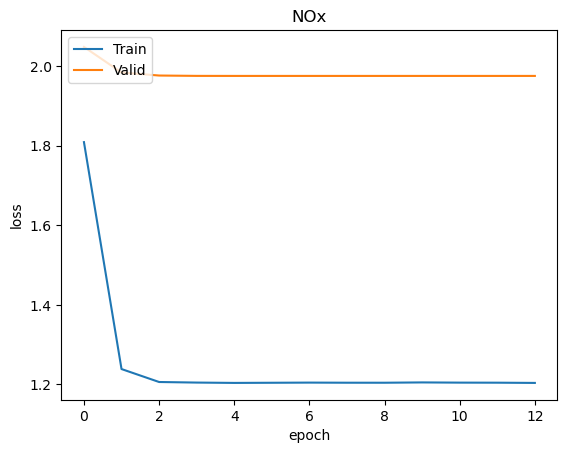

In [199]:
plot_model_learning(history_NOx, 'NOx')

In [200]:
rmsle_CO = float(rmsle(Yval_seq_CO, Y_CO_val))
rmsle_C6H6 = float(rmsle(Yval_seq_C6H6, Y_C6H6_val))
rmsle_NOx = float(rmsle(Yval_seq_NOx, Y_NOx_val))

結果：NOxが上手く出ない

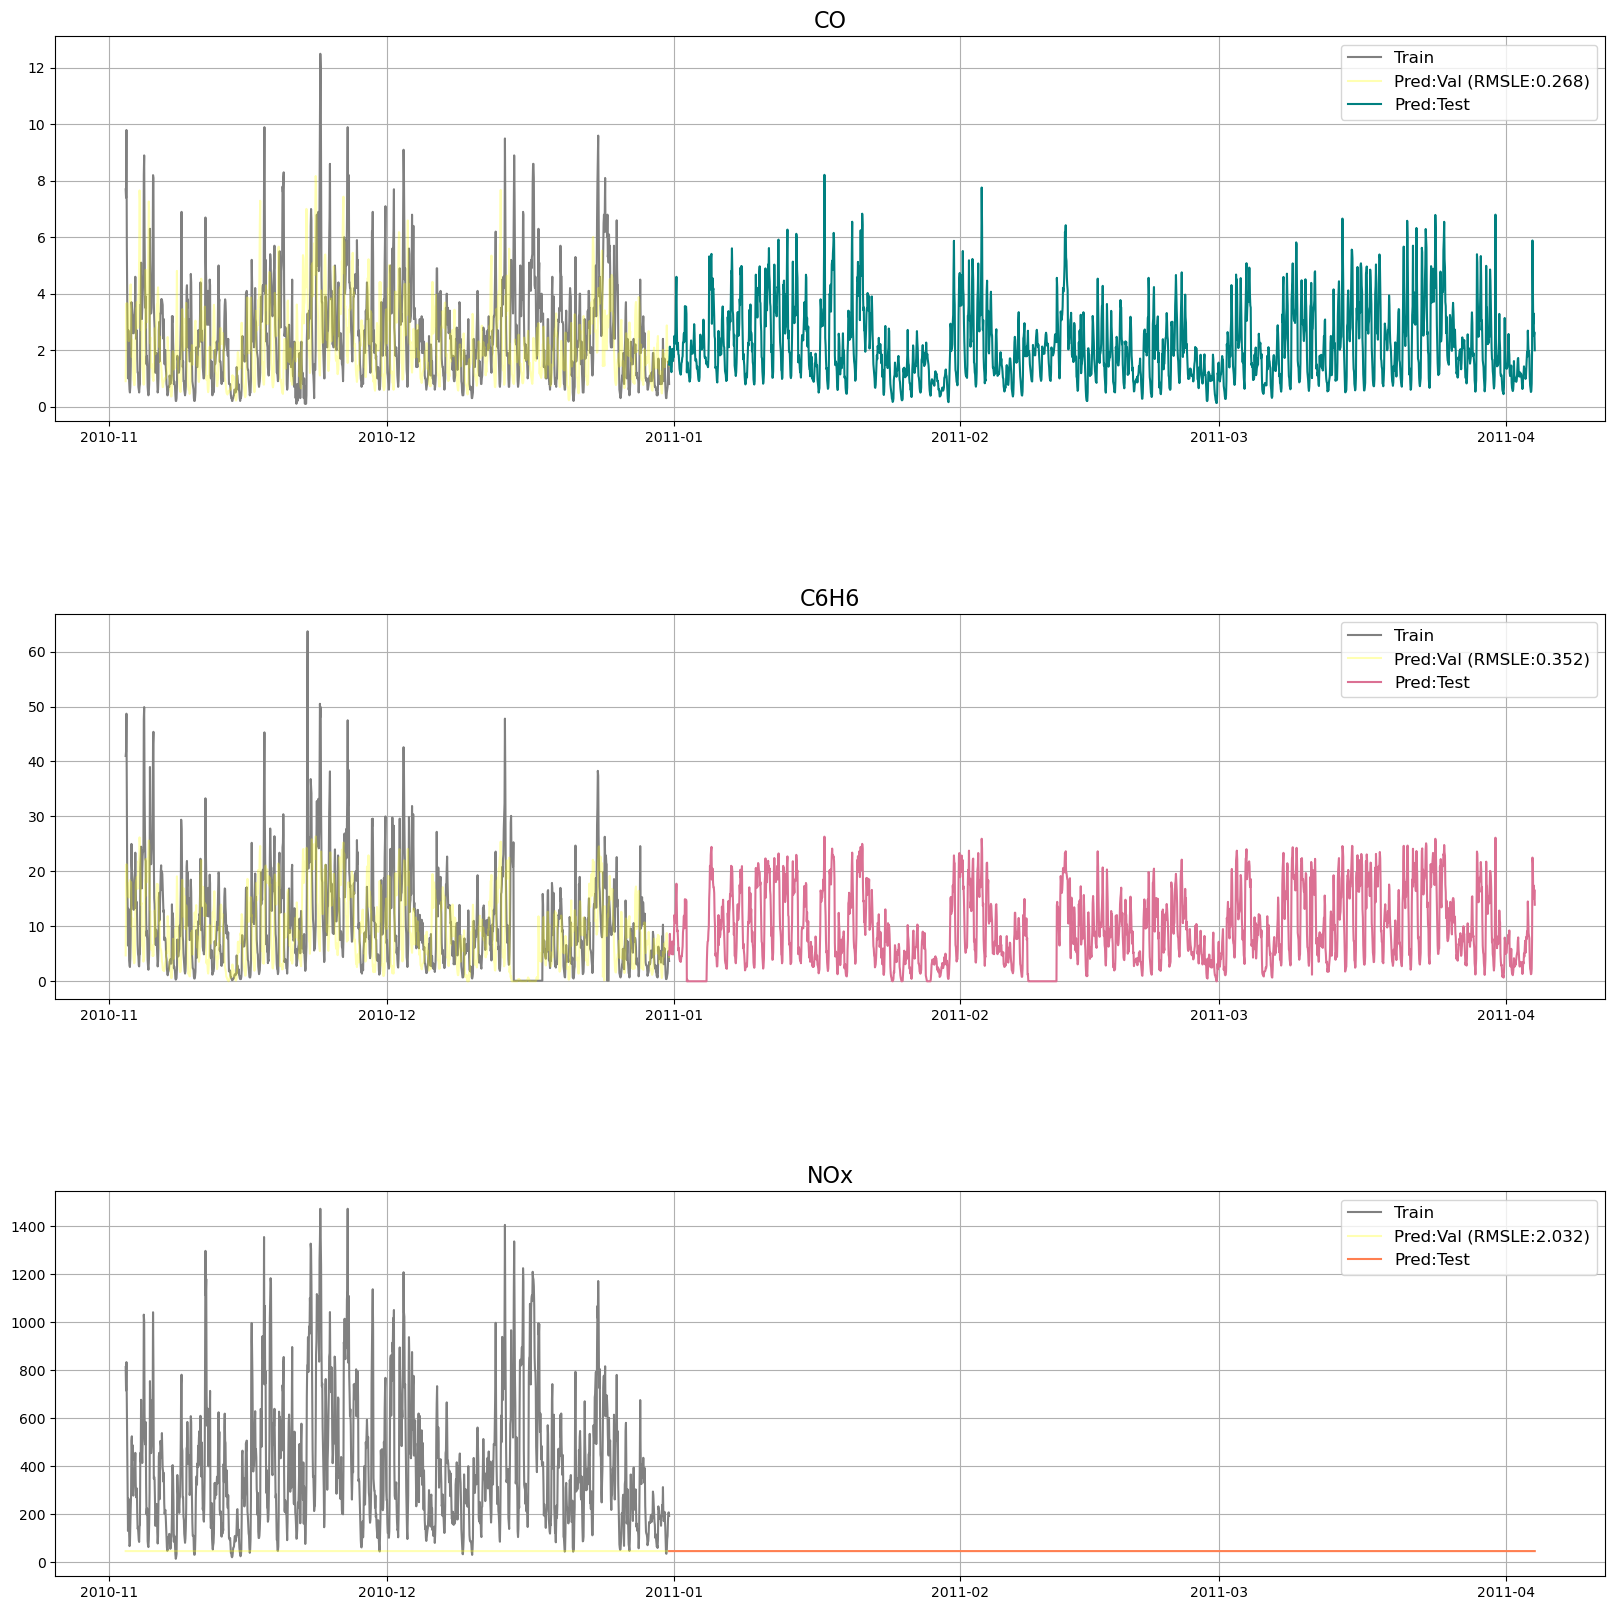

In [201]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

train_scaler, val_scaler = train_test_split(df_train, shuffle = False, train_size=0.8)

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'Yval_seq_{target_names[i]}'
    name2 = f'Y_{target_names[i]}_val'
    name3 = f'Y_{target_names[i]}'
    name4 = f'rmsle_{target_names[i]}'


    axs[i].plot(val_scaler.index[:-12], val_scaler[targets[i]][:-12], color='gray', label='Train')
    axs[i].plot(val_scaler.index[:-12], globals()[name2], color='yellow', alpha=0.3, label=f'Pred:Val (RMSLE:{globals()[name4]:.3f})')
    axs[i].plot(df_test.index[:-12], globals()[name3], color=colors[i], label='Pred:Test')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend(fontsize=12)

plt.show()

In [202]:
submit_base = pd.read_csv('sample_submission.csv')

submit = pd.DataFrame()

submit['date_time'] = submit_base['date_time']
submit[targets[0]] = Y_CO
submit[targets[1]] = Y_C6H6
submit[targets[2]] = Y_NOx

submit.to_csv('submission_LSTM.csv', index=False)